In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import ast
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

import datetime as dt

In [2]:
#!pip install SPARQLWrapper

(!pip install -U scikit-learn)

# **STEP 0: Data opening and preprocessing**

The data in the CMU Movie Summary Corpus contains a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age):

**Data:**
1. `plot_summaries.txt.gz` [29 M]: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
2. `corenlp_plot_summaries.tar.gz` [628 M, separate download]: to downlaod if considered useful... The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

**Metadata:**
1. `movie.metadata.tsv.gz` [3.4 M]: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)
2. `character.metadata.tsv.gz` [14 M]: Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

**Test data**:
1. `tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
2. `name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

## Data loading

In [3]:
data_folder = './MovieSummaries/'
characters = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)
movies = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
character_types = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep='\t', header=None)

In [4]:
characters.columns =['Wikipedia_movie_ID', 
                     'Freebase_movie_ID', 
                     'Movie_release_date', 
                     'Character_name', 
                     'Actor_birth', 
                     'Actor_Gender', 
                     'Actor Height', 
                     'Actor_Ethnicity', 
                     'Actor_Name', 
                     'Age_at_movie_release', 
                     'Freebase_character_actor_map_ID', 
                     'Freebase_character_ID', 
                     'Freebase_actor_ID']

movies.columns =['Wikipedia_movie_ID', 
                 'Freebase_movie_ID', 
                 'Name',
                 'Release_date', 
                 'Box_office_revenue', 
                 'Runtime',
                 'Languages', 
                 'Countries', 
                 'Genres']

plot_summaries.columns =['Wikipedia_movie_ID', 'Summary']
character_types.columns =['Type', 'Info']
name_clusters.columns =['Character_name', 'Freebase_character_actor_map_ID']

## Dataframes pre-processing 

### `characters` 

Each row is a character paired to an actor in a single movie, columns correspond to features that describe the characters, the actor that embodies them and the movie in which they appear. To get a better understanding, note that a single character can be played by multiple actors (e.g. James Bond) and that a single actor can have multiple roles. 

In [5]:
characters.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


In [6]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia_movie_ID               450669 non-null  int64  
 1   Freebase_movie_ID                450669 non-null  object 
 2   Movie_release_date               440674 non-null  object 
 3   Character_name                   192794 non-null  object 
 4   Actor_birth                      344524 non-null  object 
 5   Actor_Gender                     405060 non-null  object 
 6   Actor Height                     154824 non-null  float64
 7   Actor_Ethnicity                  106058 non-null  object 
 8   Actor_Name                       449441 non-null  object 
 9   Age_at_movie_release             292556 non-null  float64
 10  Freebase_character_actor_map_ID  450669 non-null  object 
 11  Freebase_character_ID            192804 non-null  object 
 12  Fr

Note that only the fetaures `Wikipedia_movie_ID`, `Freebase_movie_ID` and `Freebase_character_actor_map_ID` do not contain missing values. In particular we can see below that only `Freebase_character_actor_map_ID` values are all unique, in fact this mapping ID is uniquely created for each single movie. It is also worth noting that the number of characters (192794) is twice as lower than the number of actors (449441).

In [7]:
characters.nunique()

Wikipedia_movie_ID                  64330
Freebase_movie_ID                   64330
Movie_release_date                  18476
Character_name                     126629
Actor_birth                         29494
Actor_Gender                            2
Actor Height                          221
Actor_Ethnicity                       479
Actor_Name                         134078
Age_at_movie_release                  155
Freebase_character_actor_map_ID    450669
Freebase_character_ID              183435
Freebase_actor_ID                  135760
dtype: int64

Below is a good example to understand the subtility of this dataframe. Each row contains the information of an actor that played a particular character in a particular movie. Thus, if an actor plays the same character that appears in n movies, there will be n rows to describe their relationships where apart from the map id, only features related to the movie will change.

In [8]:
characters.loc[characters.Actor_Name == 'Roger Moore'].query("Character_name == 'James Bond'")

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
31341,6446062,/m/01kf3_9,1979-06-26,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,51.0,/m/02xg8wv,/m/0clpml,/m/017lqp
69068,6446044,/m/0g5pv3,1981-06-24,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,53.0,/m/02xg8x3,/m/0clpml,/m/017lqp
124179,583932,/m/02sg5v,1985-05-22,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,57.0,/m/02xg8xd,/m/0clpml,/m/017lqp
149343,6223567,/m/0fxmbn,1974-12-19,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,47.0,/m/02xg8w8,/m/0clpml,/m/017lqp
202846,6446061,/m/0g5pvv,1973-06-27,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,45.0,/m/02xg8v_,/m/0clpml,/m/017lqp
234294,541642,/m/02n72k,1983-06-06,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,55.0,/m/02k8g9d,/m/0clpml,/m/017lqp
425243,6446036,/m/0g5ptf,1977-07-07,James Bond,1927-10-14,M,1.85,/m/02w7gg,Roger Moore,49.0,/m/02xg8wk,/m/0clpml,/m/017lqp


Now that we have understood the structure of the `characters` dataframe, we would like to retrieve the wikidata items corresponding to the freebase IDs contained in `Actor_Ethnicity`, to add an extra feature to our dataframe. To do so we will use the wikidata query service through the sparqlwrapper package.

In [9]:
#print all freebase with format corresponding to the wikidata query service. Then manually copy pasted
ethnicity_id = list(characters['Actor_Ethnicity'].value_counts().index)
for e in ethnicity_id : print('"'+e+'"',end=' ')

"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m

In [10]:
#https://rdflib.github.io/sparqlwrapper/

#Below the query is made in two steps to respect the maximal size of the function's capacity

endpoint_url = "https://query.wikidata.org/sparql"

query1 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/044038p" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m/02jvpv" "/m/0dbxy" "/m/02vsw1" "/m/08cjt2" "/m/013s3n" "/m/09zyn5" "/m/0cm7w1" "/m/04q7gbh" "/m/0fj1k9" "/m/0fqp6zk" "/m/04f581" "/m/012c1l" "/m/071x0k" "/m/0ffjqy" "/m/0ffkb4" "/m/0g5y6" "/m/0bzkm2" "/m/0dllcfn" "/m/04y8_bm" "/m/03gskx0" "/m/0268d21" "/m/019lrz" "/m/02p4q5p" "/m/04czx7" "/m/02p656s" "/m/0ffhz3" "/m/04jq32s" "/m/04mmhj" "/m/0dj8k3" "/m/059_w" "/m/01kg2v" "/m/0222hg" "/m/0f0gt_" "/m/01j2qv" "/m/0ffjvd" "/m/032j30" "/m/033njm" "/m/0bs7l_v" "/m/0g48m4" "/m/022fdt" "/m/052r3t" "/m/0bfjm7" "/m/01xttr" "/m/04ydrsn" "/m/03295l" "/m/06lshc" "/m/03cbkrf" "/m/0283js_" "/m/09cqth" "/m/04nrnz" "/m/05748" "/m/025_0f0" "/m/01trsl" "/m/09vmyh" "/m/05sf2x" "/m/09gk_6h" "/m/078vc" "/m/01p7s6" "/m/017sq0" "/m/018s6c" "/m/04y29" "/m/067lts" "/m/05g0f1" "/m/0761bp" "/m/09gp4" "/m/02qv_h_" "/m/0640_7q" "/m/0912ll" "/m/013b7g" "/m/067lrj" "/m/0b79c7" "/m/09lz9zx" "/m/01swvz" "/m/01nbcy" "/m/0b0gzf" "/m/071drf" "/m/027vy0s" "/m/0150zs" "/m/0278pqj" "/m/0747611" "/m/0c2hxm" "/m/0462jl6" "/m/074w_m" "/m/04ggbzy" "/m/0hbz9xw" "/m/0152s7" "/m/0fng3k" "/m/0j4w_" "/m/0b98sy" "/m/08v2k7" "/m/0j6x8" "/m/0d9q7j" "/m/016f5d" "/m/0ffj5g" "/m/0338zd" "/m/04_tz7" "/m/027lf0d" "/m/0ch3pqf" "/m/06fczy" "/m/01mw1s" "/m/04608z" "/m/04_hr_" "/m/026cybk" "/m/01hwt" "/m/08gzsf" "/m/05vhv7" "/m/04_bc8" "/m/06rd7" "/m/0318mh" "/m/02wcbj_" "/m/0520604" "/m/07j80c" "/m/078ds" "/m/0fk1z" "/m/0dv5vw" "/m/04znbg" "/m/01sq7s" "/m/0gf5k1" "/m/03pqwy" "/m/031_sd" "/m/012f86" "/m/092h2qt" "/m/033qxt" "/m/03vghh" "/m/0bjbszh" "/m/07hyjp" "/m/03yk6g" "/m/0h1nk0k" "/m/04zjjt" "/m/02czfr" "/m/05qb937" "/m/047l_90" "/m/0bnzjx" "/m/02q206y" "/m/0665pp" "/m/07gzw5" "/m/062_25" "/m/0hj35" "/m/0bh91q8" "/m/01g0y_" "/m/07lv5x" "/m/0g4pffv" "/m/0828vj" "/m/07d_p8" "/m/04lhn7b" "/m/0fq6zlv" "/m/0268pvf" "/m/0466nw8" "/m/04pnf" "/m/02p_gby" "/m/06k6sl" "/m/0738n4" "/m/0266mf0" "/m/0cx3p" "/m/04kbvpz" "/m/07s9g04" "/m/04l_pt" "/m/026c9dq" "/m/01ylpf" "/m/0g5k7qv" "/m/01tyl3" "/m/0b__fv3" "/m/02vkd28" "/m/013s41" "/m/047948f" "/m/067lwk" "/m/03d19xz" "/m/02gx2x" "/m/021pd" "/m/013s2p" "/m/09fqz7" "/m/0ffhvl" "/m/075dhf0" "/m/02dd5z" "/m/03wbmrc" "/m/0br_8h" "/m/097nms" "/m/02cm28" "/m/0h6mqq9" "/m/09tqq8q" "/m/0301y_" "/m/0d8qh0" "/m/03h1dq9" "/m/03fk0c" "/m/026kx7g" "/m/04k02l" "/m/051wcch" "/m/026zlyd" "/m/01n94b" "/m/04dzwby" "/m/0btrm4" "/m/03ndvw" "/m/0fxmtg" "/m/04sfz4s" "/m/03cnzsg" "/m/03r_k" "/m/03f3sf" "/m/04lfc70" "/m/02vkw95" "/m/09y7x4" "/m/0fk3s" "/m/0h8mzsl" "/m/02p444n" "/m/03kbr" "/m/0bns36b" "/m/0bbcnlt" "/m/046j25" "/m/0dq1q" "/m/02rdfpy" "/m/05c60ml" "/m/0470lk" "/m/02p7gyv" "/m/0c29q8" "/m/03ck8x1" "/m/042199j" "/m/0bms44" "/m/01nft3" "/m/01d7kx" "/m/01c034" "/m/05cc9h" "/m/03cl2pz" "/m/03x_lpj" "/m/02rp50t" "/m/03m3p6w" "/m/02r_qms" "/m/086wp0" "/m/065z7w_" "/m/01f9bg" "/m/03sx6v" "/m/034s7b" "/m/0987ctr" "/m/03gy1h2" "/m/0c_lbq" "/m/03ftx7" "/m/067lv3" "/m/0g44f5" "/m/03d26m9" "/m/0165md" "/m/0dqrh8" "/m/0cc5y74" "/m/0289z8v" "/m/01267" "/m/0fpjs3j" "/m/03cdk7b" "/m/0bfrrj" "/m/04wy6k" "/m/03zcwh" "/m/0dc58y8" "/m/0g5rkt4" "/m/0647lm" "/m/04fh1b" "/m/047bp1r" "/m/09cd0m" "/m/03fvrb" "/m/025x6k1" "/m/02rm7_9" "/m/01l0ty" "/m/07s49c2" "/m/03ty8_" "/m/02m0kh" "/m/05ms3p0" "/m/0gtwjz6" "/m/0ftlzz" "/m/02pzb09" "/m/05sycg" "/m/051x6yk" "/m/01vsch" "/m/04csgrq" "/m/064b9n" "/m/09chmw" "/m/095mw2" "/m/09snp5" "/m/025tvhm" "/m/0c41n" "/m/01_5cg" "/m/025xss1" "/m/0404kdr" "/m/0ftwg" "/m/0790v" "/m/02r3wfk" "/m/03h11s3" "/m/01vr3v" "/m/0c3wsgg" "/m/06y24j" "/m/0ckk60" "/m/03lnnd" "/m/04hlx1" "/m/062zk4r" "/m/097r55" "/m/0b8yvr" "/m/0br_9j" "/m/0xff" "/m/01crfj" "/m/05mtdy" "/m/065577s" "/m/0fp4n" "/m/0301xt" "/m/01kb9y" "/m/0268xtg" "/m/05y2yj" "/m/0ffk5n" "/m/02vys3l" "/m/01h4n" "/m/0bvnws" "/m/06dy2k" "/m/08yg47" "/m/08c25t" "/m/0bvjpj" "/m/03x1x" "/m/0dn1_0" "/m/02qv716" "/m/02r11hz" "/m/06bkf" "/m/035b50" "/m/0166vx" "/m/01g3rx" "/m/06w4lv" "/m/04wysy" "/m/064pj" "/m/013z8m" "/m/04118b" "/m/064rb5l" "/m/01ywdy" "/m/01flqq" "/m/0960kn" "/m/0180zw" "/m/0463n9y" "/m/0d32d1" "/m/07n8wy" "/m/03q819" "/m/06vb7b" "/m/02pj9yr" "/m/03hf_6z" "/m/01km_m" "/m/062szv5" "/m/07g8yp" "/m/0fk55" "/m/04lgl9t" "/m/0444sm4" "/m/03m9my8" "/m/03cjjy0" "/m/03cmqbt" "/m/0b3zsn" "/m/03b_13l" "/m/0152wh" "/m/05ysft4" "/m/05sng" "/m/059v8" "/m/09c8kp" "/m/04jtjvt" "/m/04c28" "/m/03sk2" "/m/05ztd1" "/m/0dm3xpw" "/m/03hjx6f" "/m/026d074" "/m/03nvq" "/m/03nz70" "/m/029q52" "/m/02wz7j" "/m/04kdwcx" "/m/02ry8mk" "/m/07wsyr" "/m/09r2kh" "/m/04_8lfc" "/m/033qt1" "/m/012fh" "/m/08j1fb" "/m/027936c" "/m/0dtkkb" "/m/05bzpzx" "/m/04lhnps" "/m/0fp54b" "/m/01hm_" "/m/0288fw3" "/m/0ft9bs" "/m/01gr8h" "/m/09g34_" "/m/0d8qls" "/m/08xbxs" "/m/032m0b" "/m/04hqxn" "/m/068y7m" "/m/044bp_" "/m/039z49" "/m/047q05d" "/m/0c50f" "/m/01srl7" "/m/0fpxlz9" "/m/0bdynxs" "/m/01gby2" "/m/043_z22" "/m/03x_fq7" "/m/01hphz" "/m/033fjj" "/m/013y54"}.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

query2 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" }.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results1 = get_results(endpoint_url, query1)
results2 = get_results(endpoint_url, query2)

In [11]:
for result in results1["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

for result in results2["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

In [12]:
characters.Actor_Ethnicity.info()

<class 'pandas.core.series.Series'>
RangeIndex: 450669 entries, 0 to 450668
Series name: Actor_Ethnicity
Non-Null Count   Dtype 
--------------   ----- 
106058 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


Preprocessing ends here for the `characters` dataframe

In [13]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### `movies`

Each row is a movie, columns correpsond to features that describe these movies.

In [14]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."


In [15]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia_movie_ID  81741 non-null  int64  
 1   Freebase_movie_ID   81741 non-null  object 
 2   Name                81741 non-null  object 
 3   Release_date        74839 non-null  object 
 4   Box_office_revenue  8401 non-null   float64
 5   Runtime             61291 non-null  float64
 6   Languages           81741 non-null  object 
 7   Countries           81741 non-null  object 
 8   Genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


We can observe that columns `Release_date`, `Box_office_revenue` and `Runtime` each have a certain number of null values. In order to keep a maximum information, we will not drop all movies having at least one null value in their features because the other respective features might still be useful. However, the null values will be handled when working on particular features with subsets of the original dataframe.

Note that the `Release_date` feature column Dtype is 'object'. To handle the date in a simpler way with panda DataFrames we will use the DateTime type, this transformation is done below. After a first try, we found that the value of movie 62836 in the dataframe had a non-valid syntax, thus we changed its value manually.

In [16]:
movies.iloc[62836,3] =  pd.to_datetime('2010-12-02')
movies.loc[:,['Release_date']] = pd.to_datetime(movies['Release_date'])

In [17]:
movies.Release_date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 81741 entries, 0 to 81740
Series name: Release_date
Non-Null Count  Dtype         
--------------  -----         
74839 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 638.7 KB


The `Release_date` Dtype is now datetime64 and the number of null values is still the same.

Columns `Languages`, `Countries` and `Genres` have a special format. Even if they are stored as string, we can recognize dictionnaries. The keys correspond to the freebase ID of the wikidata item contained in the corresponding dictionnaries' values. We are not interested in keeping the freebase id in the scope of this project, we will therefore only retrieve the values using the regex `re` library. We can also create lists of genres for each movie instead of a long string in the `Genres` column. This pre-processing is done below.

In [18]:
movies.loc[:,['Genres']] = movies[['Genres']].applymap(ast.literal_eval) # transform string -> dict

In [19]:
def replace_dicts(arg):
    return list(arg.values())

movies[['Genres']] = movies[['Genres']].applymap(replace_dicts) # transform dict -> list of values

In [20]:
movies['Languages'] = movies['Languages'].apply(lambda x: re.findall('": "(.*)"', x)).str[0] # string -> string
movies['Countries'] = movies['Countries'].apply(lambda x: re.findall('": "(.*)"', x)).str[0] # string -> string

Preprocessing ends here for the `movies` dataframe

In [21]:
movies.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."


### `plot_summaries`

to do

### `character_types`

to complete

In [22]:
character_types.head(1)

,Type,Info
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."


In the `character_types` dataframe above, the `Info` column contains long strings that give information about the character that the type describes, the movie in which the character is found, the Freebase character/actor map ID and the actor that embodies the character. All of this information can be separated into four disctint columns: character, movie, ID and actor columns, using the `json` library as below. 

In [23]:
character_types[['char', 'movie', 'Freebase_character_actor_map_ID', 'actor']] = character_types['Info'].apply(lambda x: json.loads(x)).apply(pd.Series)
character_types.drop('Info', axis=1, inplace=True)

In [24]:
character_types.head(1)

,Type,char,movie,Freebase_character_actor_map_ID,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams


### `name_clusters`

to do

### First vizualisations

In [25]:
print(f'Movies dataframe has {len(movies)} rows')
print(f'Characters dataframe has {len(characters)} rows')
print(f'Plot_summaries dataframe has {len(plot_summaries)} rows')
print(f'Character_types dataframe has {len(character_types)} rows')
print(f'Name_clusters dataframe has {len(name_clusters)} rows')

Movies dataframe has 81741 rows
Characters dataframe has 450669 rows
Plot_summaries dataframe has 42303 rows
Character_types dataframe has 501 rows
Name_clusters dataframe has 2666 rows


Therefore, each of our dataframes do not have the same number of rows... However, we can still try to combine some dataframes together, such as `movies` and `plot_summaries` dataframes. This will be done further down below.

Fist intuitive plots to make are the number of movies released per year and the mean box office revenue per year. To do so, a new dataframe containing one row per year is created and contains the evolution of features we want to analyze.

In [26]:
movies_datetime = movies.dropna() # removes missing values
movies_datetime = movies_datetime.groupby((pd.to_datetime(movies_datetime['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x),
}))

In [27]:
movies_datetime.head()

,mean_runtime,mean_box_office_revenue,num_movies
Release_date,,,
1914,74.0,2.447000e+05,1.0
1915,190.0,5.000000e+07,1.0
1920,147.0,4.500000e+06,1.0
1921,102.0,2.633333e+06,3.0
1923,84.5,3.834395e+06,2.0


<AxesSubplot:>

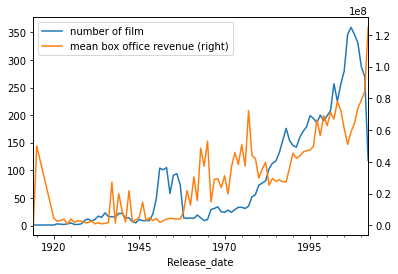

In [28]:
movies_datetime.num_movies.plot(grid=True, label="number of film", legend=True)
movies_datetime.mean_box_office_revenue.plot(secondary_y=True, label="mean box office revenue", legend=True)

In [29]:
print(f'Movie years of release span from {movies_datetime.index.min()} to {movies_datetime.index.max()}.')
print('Our dataset has', (movies_datetime.num_movies==0).sum(), 'year(s) where no films where released.')

Movie years of release span from 1914 to 2012.
Our dataset has 0 year(s) where no films where released.


Since there is no year without a movie release, any distribution of a movie characteristic will be continuous over time and will therefore be possible to analyze. Moreover, there could be a correlation between the number of movies and the box office revenue. However, with this first plot, we cannot conclude anything yet.

<AxesSubplot:>

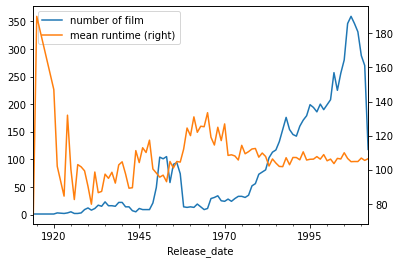

In [30]:
movies_datetime.num_movies.plot(grid=True, label="number of film", legend=True)
movies_datetime.mean_runtime.plot(secondary_y=True, label="mean runtime", legend=True)

In [31]:
np.mean(movies_datetime.mean_runtime)

107.08092609768109

The movie runtimes fluctuate during the first 50 years of our dataframe but then stabilized around 100 minutes from 1970 onwards. However, this shows that we will have to pay attention to the 'weights' applied to the years. Indeed during first 50 years there is a lot of variability in the mean runtime but the fact that these years contain only a few movies makes it difficult to estimate a global tendency. These underrepresented years might need to be grouped together. In comparison, the fluctuations are much less important during the last 50 years but the movie sample sizes are larger for each year, thus by law of large numbers, the means will be closer to the expected value (the reasoning is valable if we assume that the expected mean runtime is the same for each year).

*A voir si c'est utile d'ajouter les plots directement au movie dataset...*

### Dataframe combinations

In [32]:
movies_plot = movies.merge(plot_summaries, on="Wikipedia_movie_ID")
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."


In [33]:
merge_characters_type = pd.merge(characters, character_types, on='Freebase_character_actor_map_ID', suffixes=('', '_y'))


In [34]:
merge_characters_type.drop(['char','actor'],axis=1, inplace=True)


In [35]:
merge_characters_type = pd.merge(merge_characters_type, movies[['Wikipedia_movie_ID', 'Languages', 'Countries', 'Genres', 'Box_office_revenue', 'Runtime']], on='Wikipedia_movie_ID', suffixes=('', '_y'))
merge_characters_type.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Type,movie,Languages,Countries,Genres,Box_office_revenue,Runtime
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,Jewish people,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,Straw Dogs,English Language,"United States of America"", ""/m/07ssc"": ""United...","[Thriller, Drama]",11148828.0,118.0


# **STEP 1: Dictionnary definitions**

Trick: could add spaces in front of words that are ambiguous. Example below with SS: a lot of words contain the sequence ss, but space+ss is rare. We could even consider space+ss++space, but this would exclude some occurances due to punctuation.

### Worl War 1

In [36]:
WW1 =  ['WW1', 'World War 1', '1914', '1918', 'Allies', 'armistice', 'Central Powers', 'conscription', 'front line', 'Joffre', 'Kaiser', 'Marne',
        'mustard gas', 'no man’s land', 'Pétain', 'u boats', 'Somme', 'Tommy', 'Treaty of Versailles', 'trench', 'Verdun', 'Western front', 
        'zeppelin', 'artillery', 'doughboy', 'duckboards', 'dreadnought', 'mobilize', 'Prussia', 'Schlieffen plan', 'Tsar', 'Archduke Ferdinand',
        'Red Baron', 'big four', 'Christmas truce', 'Wilson', 'Lusitania', 'Battalion', 'triple entente', 'Great War', 'flamethrower', 'mills bomb',
        'storm troop', 'ace', 'recco', 'tailspin', 'boche', 'wipers', 'kiwi', 'Sammy', 'Aussie', 'cootie', 'Flanders', 'mud', 'war effort', 
        'League of Nations']
WW1 = [x.lower() for x in WW1]

### World War 2

In [37]:
WW2 =  ['Allies','Auschwitz','Bombardment', 'battleship', 'Bailey bridge', 'Blitzkrieg','Churchill','D-Day',' ss'
        'Dunkirk', 'Doolittle', 'de Gaulle','English Channel', 'Eisenhower','Enigma','flying tigers', 'free french',
        'nazi','helmet','Hiroshima','Invasion','Luftwaffe','Manhattan Project', 'Midway','Pearl harbor','Normandy', 'Nagasaki',
        'Panzer','Roosevelt', 'Rangers','Resistance','Truman', 'Stalin', 'tank','Victory', 'V-1 rocket','doodlebugs',
        'World War II','ww2','Hitler','air raid','shelter','siren','Battle of Britain','evacuee','evacuation','gas mask',
        'spitfire', '1939', '1945']
WW2 = [x.lower() for x in WW2]

### Space race

In [38]:
Space = ['aeronautics','Alan Shepard','Apollo','Cape Canaveral','capitalism','Cold War','Communism','Gemini','heat shields', 
         'Houston','John Glenn','Laika','launch','Lunar Module','Mercury','Michael Collins','Mission Control','NASA','neil Armstrong',
         'orbit','planet','rocket','satellite','Scott Carpenter','Sergei Korolev','solar system','space','space exploration','Space Race',
         'Sputnik','superpowers','test pilot',' USA',' URSS','Yuri Gagarin']
Space = [x.lower() for x in Space]

### Metric

If we do number of words, it could depend too much on the length of the plot summary or the length and quality of the dictionnary. Thus, a min-max scaling or standardization could be usefull afterward in the feature space. 

## ?on pourrait définir un % du numbre de mot?

# **STEP 2: Apply dictionnaries to plot summaries to create new features**

For consistency, we will apply a lower case every plot summary:

In [39]:
summaries = movies_plot.Summary.apply(lambda h: h.lower())

We can create a first feature containing the count of the number of times a word from a given dictionnary appears in a plot summary. This function creates a new column in the movies_plot DF.

In [42]:
def count_dict(name, dictionnary):
    movies_plot[name] = summaries.apply(lambda summary: np.sum([summary.count(word) for word in dictionnary]))
                                          

In [45]:
count_dict('WW1', WW1)
count_dict('WW2', WW2)
count_dict('SpaceRace', Space)

In [43]:
len(movies_plot[movies_plot.WW2 > 10])

62

In [49]:
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,WW1,WW2,SpaceRace
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",1,0,1


# **STEP 2: Analysis**

In [50]:
#temporary thresholds:
ww1T = 5
ww2T = 5
SpaceT = 5

## w.r.t time

In [52]:
def time_analysis(name,thr,freq = '5y'):
    analysis = movies_plot[movies_plot[name] > thr].copy()
    
    analysis = analysis.groupby(pd.to_datetime(analysis['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x[name].count(),
            'mean_revenue' : x['Box_office_revenue'].mean(),
            'mean_runtime' : x['Runtime'].mean(),
        })
    )
    return analysis

#See how to plot better
def plot_time_analysis(time_analysis,name):
    time = time_analysis.index.to_timestamp()
    for analysis in time_analysis.columns:
        #plt.plot(time,reg.predict(x),'k-',label = f'{round(reg.coef_[0],4)} year + {round(reg.intercept_,2)}')
        plt.plot(time,time_analysis[analysis],'.',label = analysis)
        plt.legend()
        plt.xlabel('time [year]')
        plt.title(analysis+' for '+name)
        plt.show()
    

je sais pas si c'est plus parlant comme graph?

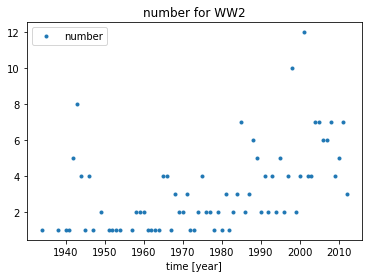

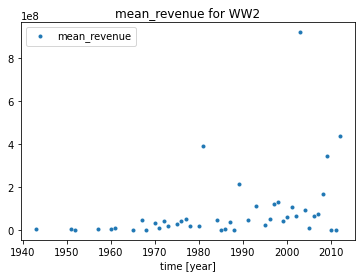

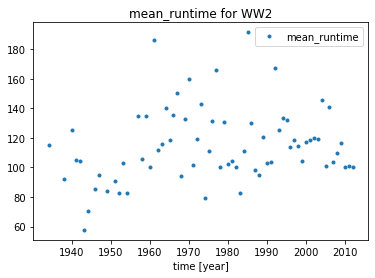

In [53]:
WW2_analysis = time_analysis('WW2',ww2T)
plot_time_analysis(WW2_analysis,'WW2')

In [60]:
print('On average, the box office revenue is: ', WW2_analysis.mean_revenue.mean(), 'and the runtime is : ', WW2_analysis.mean_runtime.mean())

On average, the box office revenue is:  86553511.61296296 and the runtime is :  114.90231292517005


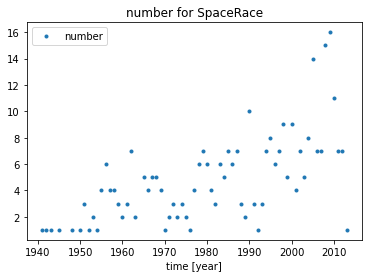

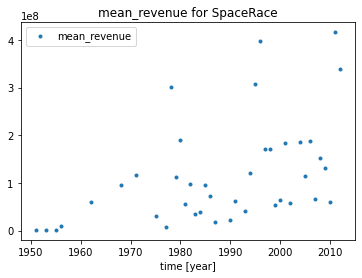

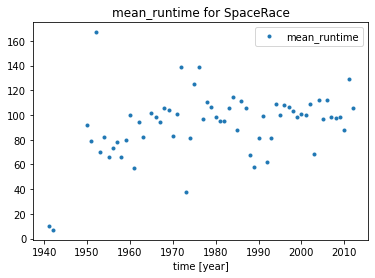

In [55]:
Space_analysis = time_analysis('SpaceRace',SpaceT)
plot_time_analysis(Space_analysis,'SpaceRace')

### Observe distribution and Linear Regression

In [61]:
def plot_distr(name,thr,xname,yname,glm=LinearRegression(),logy=False,axis=plt):
    """        
    Parameters
    ----------
    name : name of the historical event
    thr : threshold for accepting the movie as portraying the event
    xname : name of the column we want on x axis
    yname : name of the column we want on y axis
    glm : glm method to use (https://scikit-learn.org/0.15/modules/linear_model.html)
    logy : True if we want the y axis in log scale
    axis : axis to plot on, default : plt for single figure
        
    Returns
    -------
    Plots the two features selcted relative to each other and their linear regression.
    """

    time_dist = movies_plot[movies_plot[name] > thr]
    if xname=='Release_date' or yname=='Release_date' :
        pd.options.mode.chained_assignment = None  # default='warn' # get rid of warnings
        time_dist['Release_date'] = pd.to_datetime(time_dist['Release_date']).dt.year
        pd.options.mode.chained_assignment = 'warn'  # default='warn' # put warnings back
    time_dist = time_dist.dropna()
    Y = time_dist[yname]
    if logy : 
        Y = Y.apply(lambda x : np.log(x))
        yname = 'log '+ yname
    X = np.array(time_dist[xname]).reshape(-1, 1)
    
    axis.plot(time_dist[xname],Y,'.',label = f'{name} movie')
    
    
    reg = glm.fit(X,Y)
    t = np.array(np.linspace(time_dist[xname].min(),time_dist[xname].max(),1000)).reshape(-1,1)
    axis.plot(t,reg.predict(t),'-',label = str(glm))
    
    if axis == plt : #use Axes syntax
        axis.legend()
        axis.xlabel(xname)
        axis.ylabel(yname)
        axis.title(f'{yname} distribution for {name} event')
    else : #use Axes.subplots syntax
        axis.legend()
        axis.set_xlabel(xname)
        axis.set_ylabel(yname)
        axis.set_title(f'{yname} distribution for {name} event')

    return 

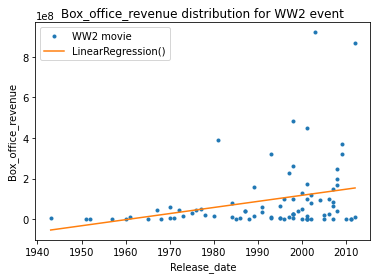

In [57]:
plot_distr('WW2',ww2T,'Release_date','Box_office_revenue')

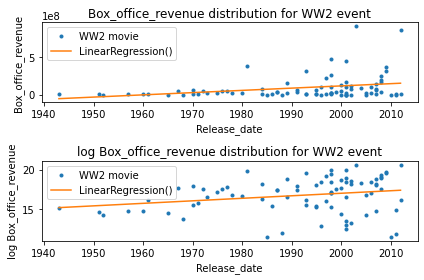

In [58]:
fig, ax = plt.subplots(2)
plot_distr('WW2',ww2T,'Release_date','Box_office_revenue',axis=ax[0])
plot_distr('WW2',ww2T,'Release_date','Box_office_revenue',logy=True,axis=ax[1])
plt.tight_layout()
plt.show()

## Movie Genres analysis

In [62]:
movies_plot['Genres'] = movies_plot['Genres'].apply(lambda x: ', '.join(map(str, x)))
movies_plot.Genres = movies_plot.Genres.apply(lambda h: h.lower())
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,WW1,WW2,SpaceRace
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"thriller, science fiction, horror, adventure, ...","Set in the second half of the 22nd century, th...",1,0,1


In [64]:
genre_list = []
for genres in movies_plot['Genres']: # genres is a string of genres
    for genre in genres.split(', '): # genre is a single genre
        if genre not in genre_list:
            genre_list.append(genre) # add genre to the list of genres

In [65]:
len(genre_list)

364

In [66]:
genre_list

['thriller',
 'science fiction',
 'horror',
 'adventure',
 'supernatural',
 'action',
 'space western',
 'erotic thriller',
 'psychological thriller',
 'drama',
 'family film',
 'fantasy',
 'world cinema',
 'romantic comedy',
 'ensemble film',
 'comedy-drama',
 'comedy',
 'romantic drama',
 'romance film',
 'costume drama',
 'war film',
 'epic',
 'period piece',
 'film adaptation',
 'animation',
 'short film',
 "children's/family",
 'musical',
 "children's fantasy",
 '',
 'indie',
 'crime fiction',
 'coming of age',
 'bollywood',
 'fan film',
 'black comedy',
 'action/adventure',
 'cult',
 'adventure comedy',
 'slapstick',
 'sports',
 'family drama',
 'biographical film',
 'historical fiction',
 'black-and-white',
 'biopic [feature]',
 'culture & society',
 'biography',
 'documentary',
 'christmas movie',
 'television movie',
 'action comedy',
 'blaxploitation',
 'martial arts film',
 'erotica',
 'sci-fi horror',
 'satire',
 'western',
 'softcore porn',
 'sexploitation',
 'mystery',
 '

In [67]:
movies_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Historical', 'Horror', 'Satire', 'Science finction', 'Speculative',
                 'Thriller', 'Western', 'Drama', 'Horror', 'Documentary', 'Musical', 'Romance','Mystery', 'War', 'Biography', 'History',
                 'zombie film', 'Alien', 'Musical', 'anti-war', 'Black-and-white', 'Cold war', 'combat', 'Conspiration', 'crime', 
                'Documentary', 'Erotic', 'Gay', 'LGBT', 'Political', 'Romantic']
movies_genres = [x.lower() for x in movies_genres]

In [68]:
for genre in movies_genres:
    movies_plot[genre] = movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)) 

In [69]:
dictionnary_genres = pd.DataFrame()

In [70]:
dictionnary_genres['WW1'] = movies_plot[movies_plot['WW1'] > ww1T][movies_genres].sum()
dictionnary_genres['WW2'] = movies_plot[movies_plot['WW2'] > ww2T][movies_genres].sum()
dictionnary_genres['SpaceRace'] = movies_plot[movies_plot['SpaceRace'] > SpaceT][movies_genres].sum()
dictionnary_genres.head()

,WW1,WW2,SpaceRace
action,292,75,135
adventure,321,64,176
comedy,326,36,74
fantasy,116,11,51
historical,14,8,1


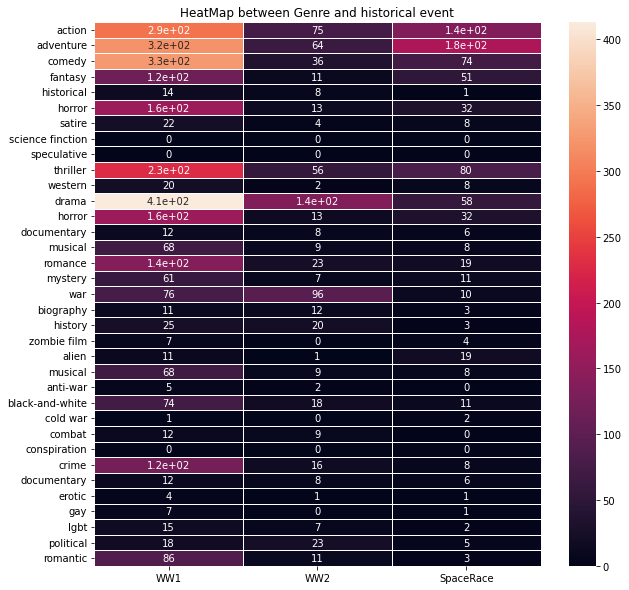

In [71]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap( dictionnary_genres, linewidth = 1 , annot = True)
plt.title( "HeatMap between Genre and historical event" )
plt.show()

In [75]:
erotique_analysis=time_analysis('erotic', 0, freq='2y')
gay_analysis=time_analysis('gay', 0, freq='2y')
lgbt_analysis=time_analysis('lgbt', 0, freq='2y')
WW1_analysis=time_analysis('WW1', 0, freq='2y')

<AxesSubplot:>

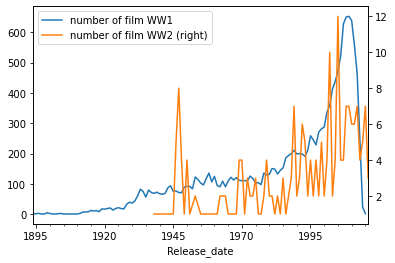

In [76]:
WW1_analysis.number.plot(grid=True, label="number of film WW1", legend=True)
WW2_analysis.number.plot(secondary_y=True, label="number of film WW2", legend=True)

<AxesSubplot:xlabel='Release_date'>

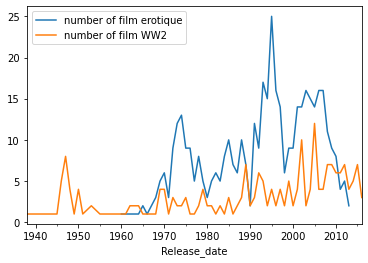

In [77]:
erotique_analysis.number.plot(grid=True, label="number of film erotique", legend=True)
WW2_analysis.number.plot(label="number of film WW2", legend=True)

<AxesSubplot:xlabel='Release_date'>

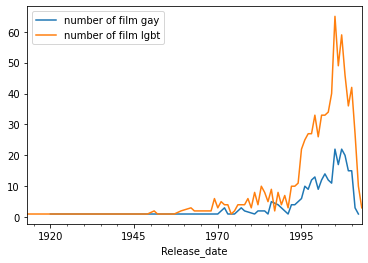

In [78]:
gay_analysis.number.plot(label="number of film gay", legend=True)
lgbt_analysis.number.plot(label="number of film lgbt", legend=True)

## PCA 

Let's define the features we will use in the PCA and that we will normalize. We could define more features by introducing character information i.e. gender ratio, age, height etc.. just need computation and fusion of DF.

-> start simple with 4 variables: box office, and the 3 events we have already

In [80]:
features = ['Box_office_revenue','WW1','WW2','SpaceRace']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature)
print(np.mean(PCAfeature,axis = 0),np.std(PCAfeature,axis = 0))

[ 2.66910083e-17 -5.66598596e-17 -3.27784312e-17  1.31113725e-17] [1. 1. 1. 1.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


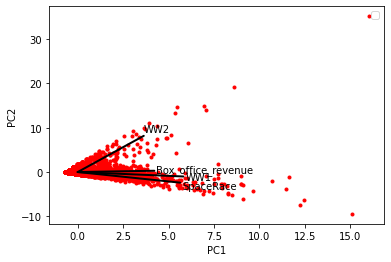

In [81]:
pca = PCA(2)  
projected = pca.fit_transform(PCAfeature)


ax = plt.gca()
arrowprops = dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0)

for i,f in enumerate(features):
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= arrowprops)
    
plt.plot(projected[:, 0], projected[:, 1],'r.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## Kmean analysis

The same question is asked here, which features should we choose... For now, we will choose the same ones as in the PCA section.

In [84]:
features = ['Box_office_revenue','WW1','WW2','SpaceRace']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature) #
kmeans = KMeans(n_clusters=4, random_state=1).fit(PCAfeature)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

We will plot the Kmean onto the 2 first PC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


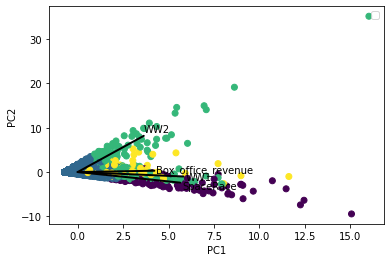

In [85]:
ax = plt.gca()
arrowprops = dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0)

for i,f in enumerate(features):
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= arrowprops)
    
plt.scatter(projected[:, 0], projected[:, 1],c = kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Some vizualisation (Nono's excellent code)

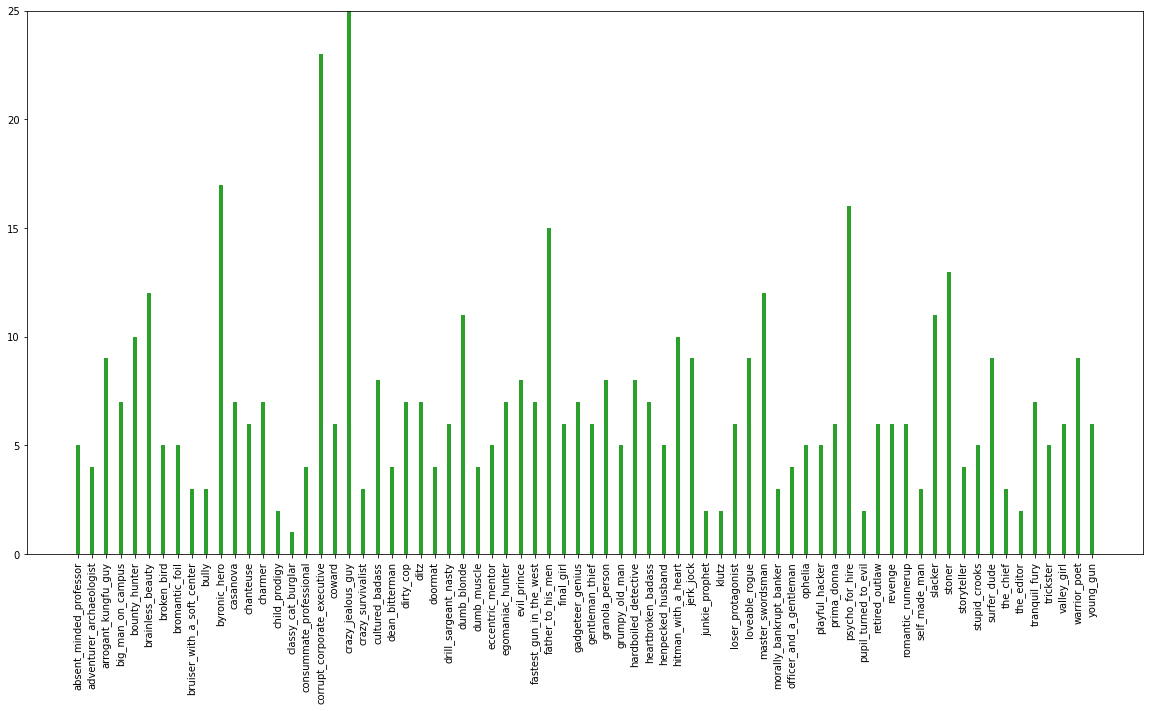

In [86]:
#number of movies in which a particular character type is present.
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [len(c)]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C2', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

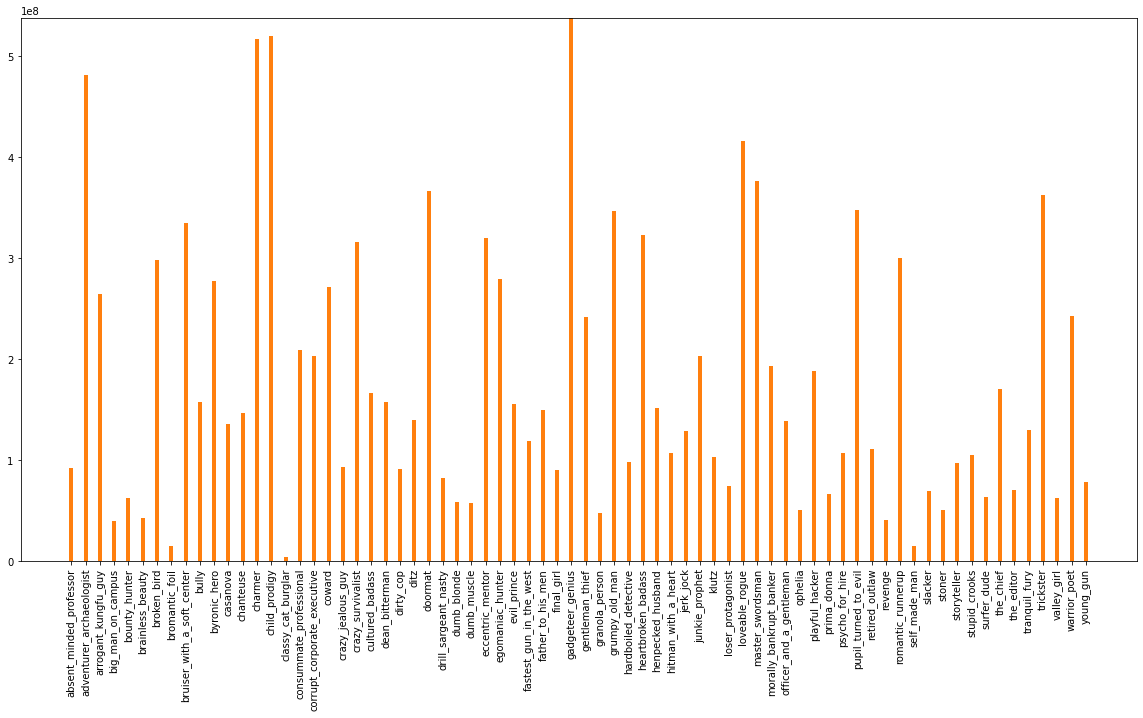

In [87]:
#mean box office revenue of movies in which a particular character type is present.
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [c.Box_office_revenue.mean()]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C1', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

In [88]:
merge_characters_type.Type.value_counts()

crazy_jealous_guy              25
corrupt_corporate_executive    23
byronic_hero                   17
psycho_for_hire                16
father_to_his_men              15
                               ..
pupil_turned_to_evil            2
the_editor                      2
junkie_prophet                  2
child_prodigy                   2
classy_cat_burglar              1
Name: Type, Length: 72, dtype: int64

look for the crazy jalouse guy

In [98]:
Crazy_jalous_guy = merge_characters_type.loc[merge_characters_type['Type'].isin(['crazy_jealous_guy'])]
Crazy_jalous_guy.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Type,movie,Languages,Countries,Genres,Box_office_revenue,Runtime
7,142457,/m/011yqc,1997-05-14,Bud White,1964-04-07,M,1.80,Māori,Russell Crowe,33.0,/m/0j_n0t,/m/02h75l1,/m/06dv3,crazy_jealous_guy,L.A. Confidential,English Language,United States of America,"[Thriller, Mystery, Crime Fiction, Drama]",126216940.0,136.0
20,1094719,/m/045j3w,2004-10-22,Takeo,1960-04-02,M,NaN,NaN,Takashi Matsuyama,44.0,/m/0hgc9dq,/m/0hgc9dt,/m/0drj3_,crazy_jealous_guy,The Grudge,"Japanese Language"", ""/m/02h40lc"": ""English Lan...","United States of America"", ""/m/03_3d"": ""Japan","[Thriller, Horror, Supernatural, Mystery, Haun...",187281115.0,97.0
40,301314,/m/01rxyb,2003-10-10,Bill,1936-12-08,M,1.85,Scottish American,David Carradine,66.0,/m/0j_fvv,/m/03py3d,/m/02p5hf,crazy_jealous_guy,Kill Bill Volume 1,"French Language"", ""/m/03_9r"": ""Japanese Langua...",United States of America,"[Thriller, Spaghetti Western, Action/Adventure...",180949045.0,112.0


In [99]:
b = Crazy_jalous_guy.groupby((pd.to_datetime(Crazy_jalous_guy['Movie_release_date']).dt.to_period(freq='10Y'))).apply(lambda x: pd.Series({
    'mean_height': x['Actor Height'].mean(),
    'mean_age' : x['Age_at_movie_release'].mean(),
    'mean_revenue' : x['Box_office_revenue'].mean(),
    'mean_runtime' : x['Runtime'].mean(),
    'number': x.Type.value_counts(), #verify that the number is not zero for a time period 
}))

In [100]:
b.head(1)

,mean_height,mean_age,mean_revenue,mean_runtime,number
Movie_release_date,,,,,
1939,1.78,31.0,624643.0,104.0,"crazy_jealous_guy 1 Name: Type, dtype: int64"


<AxesSubplot:>

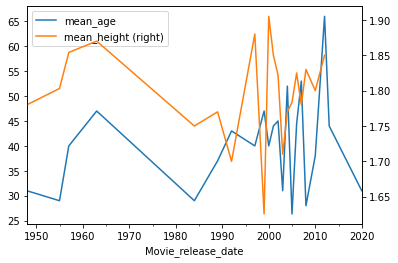

In [101]:
#plot mean age and mean height of crazy jealous guy depending on the movie release date
b.mean_age.plot(grid=True, label="mean_age", legend=True)
b.mean_height.plot(secondary_y=True, label="mean_height", legend=True)

<AxesSubplot:>

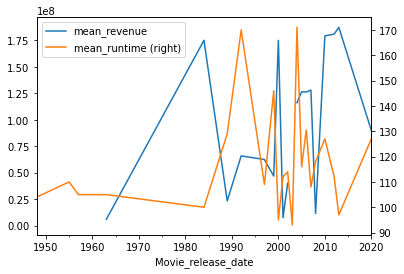

In [102]:
#plot mean revenue and mean runtime of movies with a crazy jealous guy depending on the movie release date
b.mean_revenue.plot(grid=True, label="mean_revenue", legend=True)
b.mean_runtime.plot(secondary_y=True, label="mean_runtime", legend=True)

In [104]:
Crazy_jalous_guy.Actor_Ethnicity.value_counts() # mostly american

Italian Americans         4
Scottish American         2
English people            2
Māori                     1
Scotch-Irish Americans    1
German Americans          1
Kiwi                      1
Swedish Americans         1
Jewish people             1
Irish people              1
Danish Americans          1
British people            1
Name: Actor_Ethnicity, dtype: int64

In [105]:
Crazy_jalous_guy.movie.is_unique

True

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

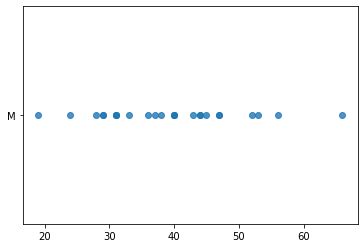

In [107]:
sns.regplot(x='Age_at_movie_release', y='Actor_Gender', data=Crazy_jalous_guy, logistic=True, ci=None)